In [2]:
from __future__ import division
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from nets import inception_utils, inception_v3 
from glob import glob
import imageio
import sys
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
import pickle
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.misc import imresize
import multiprocessing as mp
from cv2 import resize
from skimage.color import rgb2gray
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
os.environ["CUDA_VISIBLE_DEVICES"]="1" #for training on gpu

slim = tf.contrib.slim
arg_scope = tf.contrib.framework.arg_scope

SEED = 2026
np.random.seed(SEED)
tf.random.set_random_seed(SEED)



In [3]:
# Load training labels and image paths stored in csv files

normal_train_df = pd.read_csv("./data/augmented_df/aug_normal_train_df.csv", index_col=[0,1])
normal_train_df_idx = list(set(normal_train_df.index.values))

abnormal_train_df = pd.read_csv("./data/augmented_df/aug_abnormal_train_df.csv", index_col=[0,1])
abnormal_train_df_idx = list(set(abnormal_train_df.index.values))

In [4]:
# Load training images

def get_normal_train_imgs(idx):
    df_idx = normal_train_df_idx[idx]
    img = [resize(imageio.imread(normal_train_df.loc[df_idx]["path"][0]), dsize=(299,299)), 
           resize(gaussian_filter(imageio.imread(normal_train_df.loc[df_idx]["path"][1]), sigma=0.8), dsize=(299,299))]
    label = normal_train_df.loc[df_idx]["pathology"].values
    return img, label

def get_abnormal_train_imgs(idx):
    df_idx = abnormal_train_df_idx[idx]
    img = [resize(imageio.imread(abnormal_train_df.loc[df_idx]["path"][0]), dsize=(299,299)), 
          resize(gaussian_filter(imageio.imread(abnormal_train_df.loc[df_idx]["path"][1]), sigma=0.8), dsize=(299,299))]
    label = abnormal_train_df.loc[df_idx]["pathology"].values
    return img, label

p = mp.Pool(10)
imgs_labels_normal_train = p.map(get_normal_train_imgs, [j for j in range(len(normal_train_df_idx))])
p.close()
p.join()

p = mp.Pool(10)
imgs_labels_abnormal_train = np.array(p.map(get_abnormal_train_imgs, [j for j in range(len(abnormal_train_df_idx))]))
p.close()
p.join()


In [5]:
# Load training labels and image paths stored in csv files

normal_test_df = pd.read_csv("./data/augmented_df/normal_test_df.csv", index_col=[0,1])
normal_test_df_idx = list(set(normal_test_df.index.values))

abnormal_test_df = pd.read_csv("./data/augmented_df/abnormal_test_df.csv", index_col=[0,1])
abnormal_test_df_idx = list(set(abnormal_test_df.index.values))

In [6]:
# Load training images

def get_normal_test_imgs(idx):
    df_idx = normal_test_df_idx[idx]
    img = [resize(imageio.imread(normal_test_df.loc[df_idx]["path"][0]), dsize=(299,299)), 
           resize(gaussian_filter(imageio.imread(normal_test_df.loc[df_idx]["path"][1]), sigma=1.5), dsize=(299,299))]
    label = normal_test_df.loc[df_idx]["pathology"].values
    return img, label

def get_abnormal_test_imgs(idx):
    df_idx = abnormal_test_df_idx[idx]
    img = [resize(imageio.imread(abnormal_test_df.loc[df_idx]["path"].iloc[0]), dsize=(299,299)), 
          resize(gaussian_filter(imageio.imread(abnormal_test_df.loc[df_idx]["path"].iloc[1]), sigma=1.5), dsize=(299,299))]
    label = abnormal_test_df.loc[df_idx]["pathology"].values
    return img, label

p = mp.Pool(10)
imgs_labels_normal_test = p.map(get_normal_test_imgs, [j for j in range(len(normal_test_df_idx))])
p.close()
p.join()

p = mp.Pool(10)
imgs_labels_abnormal_test = np.array(p.map(get_abnormal_test_imgs, [j for j in range(len(abnormal_test_df_idx))]))
p.close()
p.join()


In [7]:
def get_checkpoint_init_ops():
    # Restore from pre-trained inception-v3
    names_in_ckpt = [v for v in slim.get_model_variables() if v.name.find("Logits")==-1]
    global_step_reset = tf.assign(tf.train.get_or_create_global_step(), 0)
    init_ops, init_feed_dict = slim.assign_from_checkpoint("./saved_model/PRETRAIN_Inception_balancedData_concatLogits_RawForUninterpretable_299Resolution_diffLR_blurOCT_2020_6_15_4_11_53_0.0001_0.0001_0.001_3500_0.92_SEED_2026_Logits_Mixed_6_Mixed_7/model.ckpt-82665",names_in_ckpt,ignore_missing_vars=True)
    init_fn = lambda sess: sess.run(init_ops, feed_dict=init_feed_dict)
    return init_fn

g = tf.Graph()

# Set Params
MAX_EPOCH = 1000000
NUM_CLASSES = 2
TOTAL_FROM_NORMAL = len(imgs_labels_normal_train)+len(imgs_labels_normal_test)
NUM_IMG_FROM_NORMAL_TRAIN = len(imgs_labels_normal_train)
TOTAL_FROM_ABNORMAL = len(imgs_labels_abnormal_train)+len(imgs_labels_abnormal_test)
NUM_IMG_FROM_ABNORMAL_TRAIN = len(imgs_labels_abnormal_train)
NUM_IMG_FROM_NORMAL_TEST = len(imgs_labels_normal_test)
NUM_IMG_FROM_ABNORMAL_TEST = len(imgs_labels_abnormal_test)
VALIDATION_INTERVAL = 50
BEST_DECAY = 0.8
BEST_DECAY_THRES = 0.85
with g.as_default():
    START_LR_OCT_CONV = tf.Variable(1e-04, name="START_LR_OCT_CONV")
    START_LR_CFP_CONV = tf.Variable(1e-04, name="START_LR_CFP_CONV")
    START_LR_LOGITS = tf.Variable(1e-04, name="START_LR_LOGITS")
    decay_all_lrs = [START_LR_OCT_CONV.assign(START_LR_OCT_CONV*BEST_DECAY), START_LR_CFP_CONV.assign(START_LR_CFP_CONV*BEST_DECAY), START_LR_LOGITS.assign(START_LR_LOGITS*BEST_DECAY)]
DECAY_STEP = 1500
DECAY_RATE = 0.91
RETRAIN_NAMES = ["Logits","Mixed_6","Mixed_7"]

session_config = tf.ConfigProto(log_device_placement=False)
session_config.gpu_options.allow_growth = True

RETRAIN = 0

# set log dir
with g.as_default():

    with tf.Session(config=session_config) as sess:

        sess.run(tf.global_variables_initializer())

        if sys.platform == "darwin":
            DEVICE = "/device:CPU:0"
            LOG_DIR = "./saved_model_test/Inception_" + str(START_LR) + "_" + str(DECAY_STEP) + "_" + str(DECAY_RATE)
        else:
            DEVICE = "/device:GPU:0"
            if RETRAIN:
                LOG_DIR = "./saved_model/FINETUNE_concatLogits_RawForUninterpretable_299Resolution_diffLR_blurOCT_2020_6_18_16_42_15_1e-04_1e-04_1e-04_3000_0.92_SEED_2026_Logits_Mixed_6_Mixed_7/"
            else:
                LOG_DIR = "./saved_model/FINETUNE_concatLogits_RawForUninterpretable_299Resolution_diffLR_blurOCT_" + str(time.localtime().tm_year) + "_" + str(time.localtime().tm_mon) + "_" + str(time.localtime().tm_mday) + "_" + str(time.localtime().tm_hour) + "_" + str(time.localtime().tm_min) + "_" + str(time.localtime().tm_sec) + "_" + str(sess.run(START_LR_OCT_CONV)) + "_" + str(sess.run(START_LR_CFP_CONV)) + "_" + str(sess.run(START_LR_LOGITS)) + "_" + str(DECAY_STEP) + "_" + str(DECAY_RATE) + "_SEED_" + str(SEED) + "_" + str(RETRAIN_NAMES)[1:-1].replace("', '","_")[1:-1]




In [8]:
# Fns switch '2' to '0', '0' to '1', and '1' to '1'
switch_fn = lambda x: False if x==2 else True
switch_fn = np.vectorize(switch_fn)

In [9]:
# coupling OCT/CFP images with their labels

images_cfp_normal_train = np.array([imgs_labels_normal_train[i][0][0] for i in range(len(imgs_labels_normal_train))])/255.
images_oct_normal_train = np.array([imgs_labels_normal_train[i][0][1] for i in range(len(imgs_labels_normal_train))])/255.
interpretable_labels_cfp_normal_train = switch_fn(np.array([imgs_labels_normal_train[i][1][0] for i in range(len(imgs_labels_normal_train))]))
interpretable_labels_oct_normal_train = switch_fn(np.array([imgs_labels_normal_train[i][1][1] for i in range(len(imgs_labels_normal_train))]))
original_labels_cfp_normal_train = np.array([imgs_labels_normal_train[i][1][0] for i in range(len(imgs_labels_normal_train))])
original_labels_oct_normal_train = np.array([imgs_labels_normal_train[i][1][1] for i in range(len(imgs_labels_normal_train))])

images_cfp_abnormal_train = np.array([imgs_labels_abnormal_train[i][0][0] for i in range(len(imgs_labels_abnormal_train))])/255.
images_oct_abnormal_train = np.array([imgs_labels_abnormal_train[i][0][1] for i in range(len(imgs_labels_abnormal_train))])/255.
interpretable_labels_cfp_abnormal_train = switch_fn(np.array([imgs_labels_abnormal_train[i][1][0] for i in range(len(imgs_labels_abnormal_train))]))
interpretable_labels_oct_abnormal_train = switch_fn(np.array([imgs_labels_abnormal_train[i][1][1] for i in range(len(imgs_labels_abnormal_train))]))
original_labels_cfp_abnormal_train = np.array([imgs_labels_abnormal_train[i][1][0] for i in range(len(imgs_labels_abnormal_train))])
original_labels_oct_abnormal_train = np.array([imgs_labels_abnormal_train[i][1][1] for i in range(len(imgs_labels_abnormal_train))])

In [10]:
images_cfp_normal_test = np.array([imgs_labels_normal_test[i][0][0] for i in range(len(imgs_labels_normal_test))])/255.
images_oct_normal_test = np.array([imgs_labels_normal_test[i][0][1] for i in range(len(imgs_labels_normal_test))])/255.
interpretable_labels_cfp_normal_test = switch_fn(np.array([imgs_labels_normal_test[i][1][0] for i in range(len(imgs_labels_normal_test))]))
interpretable_labels_oct_normal_test = switch_fn(np.array([imgs_labels_normal_test[i][1][1] for i in range(len(imgs_labels_normal_test))]))
original_labels_cfp_normal_test = np.array([imgs_labels_normal_test[i][1][0] for i in range(len(imgs_labels_normal_test))])
original_labels_oct_normal_test = np.array([imgs_labels_normal_test[i][1][1] for i in range(len(imgs_labels_normal_test))])

images_cfp_abnormal_test = np.array([imgs_labels_abnormal_test[i][0][0] for i in range(len(imgs_labels_abnormal_test))])/255.
images_oct_abnormal_test = np.array([imgs_labels_abnormal_test[i][0][1] for i in range(len(imgs_labels_abnormal_test))])/255.
interpretable_labels_cfp_abnormal_test = switch_fn(np.array([imgs_labels_abnormal_test[i][1][0] for i in range(len(imgs_labels_abnormal_test))]))
interpretable_labels_oct_abnormal_test = switch_fn(np.array([imgs_labels_abnormal_test[i][1][1] for i in range(len(imgs_labels_abnormal_test))]))
original_labels_cfp_abnormal_test = np.array([imgs_labels_abnormal_test[i][1][0] for i in range(len(imgs_labels_abnormal_test))])
original_labels_oct_abnormal_test = np.array([imgs_labels_abnormal_test[i][1][1] for i in range(len(imgs_labels_abnormal_test))])

In [12]:
def gen_Dataset_train():
    # Normal Imgs
    for i in range(NUM_IMG_FROM_NORMAL_TRAIN):
        ori_label_cfp = original_labels_cfp_normal_train[i]
        ori_label_oct = original_labels_oct_normal_train[i]
        one_hot_cfp = np.zeros(2)
        if ori_label_cfp != 2:
            one_hot_cfp[int(ori_label_cfp)] = 1.
        else:
            one_hot_cfp = np.array([1., 0.])
        one_hot_oct = np.zeros(2)
        if ori_label_oct != 2:
            one_hot_oct[int(ori_label_oct)] = 1.
        else:
            one_hot_oct = np.array([1., 0.])
        yield (images_cfp_normal_train[i], images_oct_normal_train[i], np.array([1., 0.]), [interpretable_labels_cfp_normal_train[i]], [interpretable_labels_oct_normal_train[i]], one_hot_cfp, one_hot_oct)
    # Abnormal Imgs
    for i in range(NUM_IMG_FROM_ABNORMAL_TRAIN):
        ori_label_cfp = original_labels_cfp_abnormal_train[i]
        ori_label_oct = original_labels_oct_abnormal_train[i]
        one_hot_cfp = np.zeros(2)
        if ori_label_cfp != 2:
            one_hot_cfp[int(ori_label_cfp)] = 1.
        else:
            one_hot_cfp = np.array([0., 1.])
        one_hot_oct = np.zeros(2)
        if ori_label_oct != 2:
            one_hot_oct[int(ori_label_oct)] = 1.
        else:
            one_hot_oct = np.array([0., 1.])
        yield (images_cfp_abnormal_train[i], images_oct_abnormal_train[i], np.array([0., 1.]), [interpretable_labels_cfp_abnormal_train[i]], [interpretable_labels_oct_abnormal_train[i]], one_hot_cfp, one_hot_oct)
        
def gen_Dataset_test():
    # Normal Imgs
    for i in range(TOTAL_FROM_NORMAL - NUM_IMG_FROM_NORMAL_TRAIN):
        yield (images_cfp_normal_test[i], images_oct_normal_test[i], np.array([1., 0.]), [interpretable_labels_cfp_normal_test[i]], [interpretable_labels_oct_normal_test[i]])
    # Abnormal Imgs
    for i in range(TOTAL_FROM_ABNORMAL - NUM_IMG_FROM_ABNORMAL_TRAIN):
        yield (images_cfp_abnormal_test[i], images_oct_abnormal_test[i], np.array([0., 1.]), [interpretable_labels_cfp_abnormal_test[i]], [interpretable_labels_oct_abnormal_test[i]])
        

In [13]:
with tf.device(DEVICE):

    tf.reset_default_graph()

    def modified_inception_v3(img_cfp, img_oct, reuse=None, create_aux_logits=False, trainable=True, global_pool=False, device=DEVICE):

        with tf.variable_scope("CFP"):
            with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
                _, end_points_cfp = inception_v3.inception_v3(img_cfp, num_classes=NUM_CLASSES, global_pool=global_pool, create_aux_logits=create_aux_logits, is_training=trainable, reuse=reuse, device=device, final_endpoint=RETRAIN_NAMES[-1]+"c")

        with tf.variable_scope("OCT"):
            with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
                _, end_points_oct = inception_v3.inception_v3(img_oct, num_classes=NUM_CLASSES, global_pool=global_pool, create_aux_logits=create_aux_logits, is_training=trainable, reuse=reuse, device=device, final_endpoint=RETRAIN_NAMES[-1]+"c")
        
        with tf.variable_scope("Final_Logits", reuse=reuse):
            pre_logits_concated = tf.concat([end_points_cfp["PreLogits"], end_points_oct["PreLogits"]], axis=3)
            logits = slim.conv2d(pre_logits_concated, NUM_CLASSES, [1, 1], activation_fn=None, 
                               normalizer_fn=None, weights_regularizer=slim.l2_regularizer(0.01), scope='Conv2d_1c_1x1')
            logits = tf.squeeze(logits, [1, 2], name='SpatialSqueeze')
            
        pred = slim.softmax(logits, scope="Prediction")
        
        return logits, pred, end_points_cfp, end_points_oct


In [ ]:
with tf.device(DEVICE):

    with g.as_default():
        img_dataset_train = tf.data.Dataset.from_generator(gen_Dataset_train, (tf.float32, tf.float32, tf.float32, tf.bool, tf.bool, tf.float32, tf.float32), (list(images_cfp_normal_train.shape[1:]), list(images_oct_normal_train.shape[1:]), [2], [1], [1], [2], [2])).repeat(25000).shuffle(5000).batch(32)
        input_cfp_train, input_oct_train, label_train, interpre_cfp, interpre_oct, ori_cfp, ori_oct = img_dataset_train.make_one_shot_iterator().get_next()

        img_dataset_val = tf.data.Dataset.from_generator(gen_Dataset_test, (tf.float32, tf.float32, tf.float32, tf.bool, tf.bool), (list(images_cfp_normal_test.shape[1:]), list(images_oct_normal_test.shape[1:]), [2], [1], [1])).repeat(25000).batch(NUM_IMG_FROM_NORMAL_TEST+NUM_IMG_FROM_ABNORMAL_TEST)
        input_cfp_val, input_oct_val, label_val, interpre_cfp_val, interpre_oct_val = img_dataset_val.make_one_shot_iterator().get_next()

        logits, pred, end_points_cfp, end_points_oct = modified_inception_v3(input_cfp_train, input_oct_train, global_pool=True, device=DEVICE)
        logits_val, pred_val, end_points_cfp_val, end_points_oct_val = modified_inception_v3(input_cfp_val, input_oct_val, global_pool=True, trainable=False, reuse=tf.AUTO_REUSE, device=DEVICE)
        accuracy_val = tf.reduce_mean(tf.cast(tf.equal(tf.math.argmax(pred_val, axis=1),tf.math.argmax(label_val, axis=1)), tf.float32), axis=0)

        best_acc = tf.Variable(0., name="BEST_ACC")
        assign_acc = best_acc.assign(accuracy_val)
        
        loss_cfp_conv = tf.losses.softmax_cross_entropy(tf.boolean_mask(ori_cfp, tf.reshape(interpre_cfp, [-1]) ), tf.boolean_mask(logits, tf.reshape(interpre_cfp, [-1]) ))
        loss_oct_conv = tf.losses.softmax_cross_entropy(tf.boolean_mask(ori_oct, tf.reshape(interpre_oct,[-1]) ), tf.boolean_mask(logits, tf.reshape(interpre_oct,[-1]) ))
        loss_combined_logits = tf.losses.softmax_cross_entropy(label_train, logits)
        
        loss_cfp_conv_regularization = tf.reduce_sum([l for l in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) if l.name.find("CFP")!=-1 and l.name.find("Logits")==-1])
        loss_oct_conv_regularization = tf.reduce_sum([l for l in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) if l.name.find("OCT")!=-1 and l.name.find("Logits")==-1])
        loss_combined_logits_regularization = tf.reduce_sum([l for l in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) if l.name.find("Final_Logits")!=-1 and l.name.find("OCT")==-1 and l.name.find("CFP")==-1])
        
        total_loss_cfp_conv = loss_cfp_conv + loss_cfp_conv_regularization
        total_loss_oct_conv = loss_oct_conv + loss_oct_conv_regularization
        total_loss_combined_logits = loss_combined_logits + loss_combined_logits_regularization
        
        loss_val = tf.losses.softmax_cross_entropy(label_val, logits_val, loss_collection="validation")

        retrain_list = []
        for v in tf.trainable_variables():
            for n in RETRAIN_NAMES:
                if n in v.name:
                    retrain_list += [v]

        learning_rate_oct_conv = tf.train.exponential_decay(START_LR_OCT_CONV, tf.train.get_or_create_global_step(), DECAY_STEP, DECAY_RATE)
        learning_rate_cfp_conv = tf.train.exponential_decay(START_LR_CFP_CONV, tf.train.get_or_create_global_step(), DECAY_STEP, DECAY_RATE)
        learning_rate_logits = tf.train.exponential_decay(START_LR_LOGITS, tf.train.get_or_create_global_step(), DECAY_STEP, DECAY_RATE)
        opt_oct_conv = tf.train.AdamOptimizer(learning_rate_oct_conv)
        opt_cfp_conv = tf.train.AdamOptimizer(learning_rate_cfp_conv)
        opt_logits = tf.train.AdamOptimizer(learning_rate_logits)
        train_tensor_cfp_conv = slim.learning.create_train_op(total_loss_cfp_conv, optimizer=opt_cfp_conv, variables_to_train=[v for v in retrain_list if v.name.find("CFP")!=-1 and v.name.find("Logits")==-1])
        with tf.control_dependencies([train_tensor_cfp_conv]):
            train_tensor_oct_conv = slim.learning.create_train_op(total_loss_oct_conv, optimizer=opt_oct_conv, variables_to_train=[v for v in retrain_list if v.name.find("OCT")!=-1 and v.name.find("Logits")==-1])
            with tf.control_dependencies([train_tensor_oct_conv]):
                train_tensor_combined_logits = slim.learning.create_train_op(total_loss_combined_logits, optimizer=opt_logits, variables_to_train=[v for v in retrain_list if v.name.find("Final_Logits")!=-1 and v.name.find("OCT")==-1 and v.name.find("CFP")==-1])
        
#         train_tensors = control_flow_ops.with_dependencies([train_tensor], train_tensor2)
        # Creat Summary
        slim.summaries.add_scalar_summary(loss_combined_logits, 'cross_entropy_loss', 'losses')
        slim.summaries.add_scalar_summary(learning_rate_oct_conv, 'learning_rate_oct_conv', 'training')
        slim.summaries.add_scalar_summary(learning_rate_cfp_conv, 'learning_rate_cfp_conv', 'training')
        slim.summaries.add_scalar_summary(learning_rate_logits, 'learning_rate_logits', 'training')
        slim.summaries.add_scalar_summary(loss_val, 'validation_loss', 'losses')
        slim.summaries.add_scalar_summary(loss_val-loss_combined_logits, 'validation_delta', 'losses')
        slim.summaries.add_scalar_summary(accuracy_val, 'validation_accuracy', 'accuracy')
        
        saver = tf.train.Saver()
    
    def train_step_fn(sess, train_op, global_step, train_step_kwargs):
        """
        slim.learning.train_step():
        train_step_kwargs = {summary_writer:, should_log:, should_stop:}
        """
        # calc training losses
        total_loss, should_stop = slim.learning.train_step(sess, train_op, global_step, train_step_kwargs)


        # validate on interval
        if global_step.eval(session=sess) % VALIDATION_INTERVAL == 0:

            acc = sess.run(accuracy_val)
            best = sess.run(best_acc)
            if acc > best:
                sess.run(assign_acc)
                saver.save(sess, LOG_DIR+"/best.ckpt")
                if acc >= BEST_DECAY_THRES:
                    sess.run(decay_all_lrs)
            
#             validiate_loss = sess.run(loss_val)

        return [total_loss, should_stop]

In [ ]:
with g.as_default():

    slim.learning.train(
        train_tensor_combined_logits,
        LOG_DIR,
        log_every_n_steps=1,
        number_of_steps=MAX_EPOCH,
        graph=g,
        save_summaries_secs=10,
        save_interval_secs=30,
        init_fn=get_checkpoint_init_ops(),
        global_step=tf.train.get_global_step(),
        train_step_fn = train_step_fn,
        session_config=session_config
        )

In [22]:
# evaluation
tf.reset_default_graph()
img_dataset_test = tf.data.Dataset.from_generator(gen_Dataset_test, (tf.float32, tf.float32, tf.float32, tf.bool, tf.bool), (list(images_cfp_normal_test.shape[1:]), list(images_oct_normal_test.shape[1:]), [2], [1], [1])).repeat(10).batch(NUM_IMG_FROM_NORMAL_TEST+NUM_IMG_FROM_ABNORMAL_TEST)
input_cfp_test, input_oct_test, label_test, interpre_cfp_test, interpre_oct_test = img_dataset_test.make_one_shot_iterator().get_next()    
logits_test, pred_test, _, _ = modified_inception_v3(input_cfp_test, input_oct_test, global_pool=True, trainable=False, reuse=tf.AUTO_REUSE, device=DEVICE)
with tf.Session(config=session_config) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, "./saved_model/FINETUNE_concatLogits_RawForUninterpretable_299Resolution_diffLR_blurOCT_2020_6_19_2_19_52_1e-04_1e-04_1e-04_1500_0.91_SEED_2026_Logits_Mixed_6_Mixed_7/best.ckpt")
#     print sess.run(pred_test)
    pred_probs = sess.run(pred_test)
    pred_results = np.argmax(sess.run(pred_test),axis=1)
    label_results = np.argmax(sess.run(label_test),axis=1)
    print np.sum(np.argmax(sess.run(pred_test),axis=1)==np.argmax(sess.run(label_test),axis=1))/(NUM_IMG_FROM_NORMAL_TEST+NUM_IMG_FROM_ABNORMAL_TEST)
    pred_thresholded = sess.run(pred_test>0.65)
    for i in range(pred_thresholded.shape[0]):
        if pred_thresholded[i,0]==pred_thresholded[i,1]==False:
            pred_thresholded[i,1]=True
    print np.sum(np.argmax(pred_thresholded,axis=1)==np.argmax(sess.run(label_test),axis=1))/(NUM_IMG_FROM_NORMAL_TEST+NUM_IMG_FROM_ABNORMAL_TEST)
    pred_thresholded = np.argmax(pred_thresholded,axis=1)
    

0.8859649122807017
0.8157894736842105


In [47]:
# Get p-values from McNemar's Test

from mlxtend.evaluate import mcnemar, mcnemar_table

df_results = pd.DataFrame.from_dict(np.hstack([label_results.reshape(-1,1), pred_results.reshape(-1,1)]))
df_results = df_results.rename(columns={0:"label",1:'pred'})

contingency_table = pd.crosstab(df_results['label'],df_results['pred']).values

mcnemar(mcnemar_table(label_results,label_results, pred_results))

(11.076923076923077, 0.0008740872112984756)

Confusion matrix, without normalization
[[51  6]
 [ 7 50]]
False Normal Rate:  0.12280701754385964
Recall:  0.8771929824561403
Speicificity:  0.8947368421052632


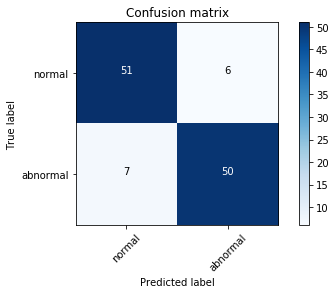

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_matrix(label_results,pred_results), classes=["normal","abnormal"])

fnr = confusion_matrix(label_results,pred_results)[1][0]/(confusion_matrix(label_results,pred_results)[1][0]+confusion_matrix(label_results,pred_results)[1][1])
recall = confusion_matrix(label_results,pred_results)[1][1]/(confusion_matrix(label_results,pred_results)[1][0]+confusion_matrix(label_results,pred_results)[1][1])
specificity = confusion_matrix(label_results,pred_results)[0][0]/(confusion_matrix(label_results,pred_results)[0][0]+confusion_matrix(label_results,pred_results)[0][1])

print "False Normal Rate: ", confusion_matrix(label_results,pred_results)[1][0]/(confusion_matrix(label_results,pred_results)[1][0]+confusion_matrix(label_results,pred_results)[1][1])
print "Recall: ", confusion_matrix(label_results,pred_results)[1][1]/(confusion_matrix(label_results,pred_results)[1][0]+confusion_matrix(label_results,pred_results)[1][1])
print "Speicificity: ", confusion_matrix(label_results,pred_results)[0][0]/(confusion_matrix(label_results,pred_results)[0][0]+confusion_matrix(label_results,pred_results)[0][1])


In [64]:
# Get CIs following https://machinelearningmastery.com/report-classifier-performance-confidence-intervals/
# Wilson score interval

def get_CI(metric):
    one_side = 1.96 * np.sqrt(metric*(1-metric)/len(pred_results))
    return metric + one_side, metric - one_side

acc = 0.8859649122807017

upper_acc, lower_acc = get_CI(acc)
upper_recall, lower_recall = get_CI(recall)
upper_specificity, lower_specificity = get_CI(specificity)

print "ACC: %.2f ~ (%.2f, %.2f)" %(acc*100, lower_acc*100, upper_acc*100)
print "RECALL: %.2f ~ (%.2f, %.2f)" %(recall*100, lower_recall*100, upper_recall*100)
print "SPEICIFICITY: %.2f ~ (%.2f, %.2f)" %(specificity*100, lower_specificity*100, upper_specificity*100)

ACC: 88.60 ~ (82.76, 94.43)
RECALL: 87.72 ~ (81.69, 93.74)
SPEICIFICITY: 89.47 ~ (83.84, 95.11)


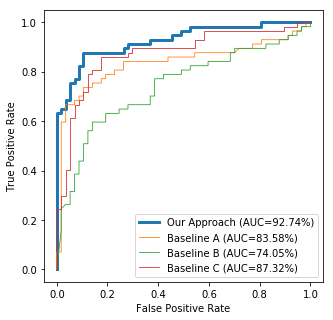

In [48]:
plt.figure(figsize=(5,5))
fpr,tpr,_ = roc_curve(y_true=label_results,y_score=pred_probs[:,1])
auc_our = auc(fpr,tpr)
plt.plot(fpr,tpr,label="Our Approach (AUC={:.2%})".format(auc_our), linewidth=3)

tpr_baseline_a = np.sort(np.loadtxt("./seperate_models/tpr_baseline_a.txt"))[::-1]
fpr_baseline_a = np.sort(np.loadtxt('./seperate_models/fpr_baseline_a.txt'))[::-1]
auc_a = auc(fpr_baseline_a, tpr_baseline_a)
plt.plot(fpr_baseline_a, tpr_baseline_a, label="Baseline A (AUC={:.2%})".format(auc_a), linewidth=0.8)

tpr_baseline_b = np.loadtxt("./seperate_models/tpr_baseline_b.txt")
fpr_baseline_b = np.loadtxt('./seperate_models/fpr_baseline_b.txt')
auc_b = auc(fpr_baseline_b, tpr_baseline_b)
plt.plot(fpr_baseline_b, tpr_baseline_b, label="Baseline B (AUC={:.2%})".format(auc_b), linewidth=0.8)

tpr_baseline_c = np.loadtxt("./tpr_baseline_c.txt")
fpr_baseline_c = np.loadtxt('./fpr_baseline_c.txt')
auc_c = auc(fpr_baseline_c, tpr_baseline_c)
plt.plot(fpr_baseline_c, tpr_baseline_c, label="Baseline C (AUC={:.2%})".format(auc_c), linewidth=0.8)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('roc.png',dpi=200)

In [72]:
## Get CI for AUC following 
#https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Confidence_Intervals_for_the_Area_Under_an_ROC_Curve.pdf
#https://cs.nyu.edu/~mohri/pub/area.pdf

def get_CI_for_auc(auc, n_pos=np.sum(label_results==1), n_neg=np.sum(label_results==0)):
    q_1 = auc/(2-auc)
    q_2 = 2*auc**2/(1+auc)
    one_side = 1.96 * np.sqrt((auc*(1-auc)+(n_pos-1)*(q_1-auc**2)+(n_neg-1)*(q_2-auc**2))/(n_pos*n_neg))
    return auc+one_side, auc-one_side

auc_our_upper, auc_our_lower = get_CI_for_auc(auc_our)
auc_a_upper, auc_a_lower = get_CI_for_auc(auc_a)
auc_b_upper, auc_b_lower = get_CI_for_auc(auc_b)
auc_c_upper, auc_c_lower = get_CI_for_auc(auc_c)

print "OUR AUC: %.2f ~ (%.2f, %.2f)" %(auc_our*100, auc_our_lower*100, auc_our_upper*100)
print "BASELINE A AUC: %.2f ~ (%.2f, %.2f)" %(auc_a*100, auc_a_lower*100, auc_a_upper*100)
print "BASELINE B AUC: %.2f ~ (%.2f, %.2f)" %(auc_b*100, auc_b_lower*100, auc_b_upper*100)
print "BASELINE C AUC: %.2f ~ (%.2f, %.2f)" %(auc_c*100, auc_c_lower*100, auc_c_upper*100)


OUR AUC: 92.74 ~ (87.71, 97.76)
BASELINE A AUC: 83.58 ~ (76.11, 91.05)
BASELINE B AUC: 74.05 ~ (64.96, 83.14)
BASELINE C AUC: 87.32 ~ (80.71, 93.93)


In [17]:
# df_example_imgs = pd.concat([normal_test_df.loc[2], normal_test_df.loc[20], abnormal_test_df.loc[104], abnormal_test_df.loc[92], abnormal_test_df.loc[159], abnormal_test_df.loc[452]])
df_example_imgs = pd.concat([normal_test_df.loc[2], normal_test_df.loc[30], abnormal_test_df.loc[104], abnormal_test_df.loc[548], abnormal_test_df.loc[159], abnormal_test_df.loc[452]])

def gen_example_imgs():
    # Normal Imgs
    for i in range(2):
        yield (resize(imageio.imread(df_example_imgs['path'].values[2*i]),dsize=(299,299))/255., resize(gaussian_filter(imageio.imread(df_example_imgs['path'].values[2*i+1]),sigma=1.5),dsize=(299,299))/255., np.array([1., 0.]))
    # Abnormal Imgs
    for i in range(2,6):
        yield (resize(imageio.imread(df_example_imgs['path'].values[2*i]),dsize=(299,299))/255., resize(gaussian_filter(imageio.imread(df_example_imgs['path'].values[2*i+1]),sigma=1.5),dsize=(299,299))/255., np.array([0., 1.]))

tf.reset_default_graph()
img_dataset_test = tf.data.Dataset.from_generator(gen_example_imgs, (tf.float32, tf.float32, tf.float32), (list(images_cfp_normal_test.shape[1:]), list(images_oct_normal_test.shape[1:]), [2])).repeat(10).batch(6)
input_cfp_test, input_oct_test, label_test = img_dataset_test.make_one_shot_iterator().get_next()    
logits_test, pred_test, end_points_cfp, end_points_oct = modified_inception_v3(input_cfp_test, input_oct_test, global_pool=True, trainable=False, reuse=tf.AUTO_REUSE, device=DEVICE)
with tf.variable_scope("",reuse=True):
    fc = tf.get_variable("Final_Logits/Conv2d_1c_1x1/weights")
with tf.Session(config=session_config) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, "./saved_model/FINETUNE_concatLogits_RawForUninterpretable_299Resolution_diffLR_blurOCT_2020_6_19_2_19_52_1e-04_1e-04_1e-04_1500_0.91_SEED_2026_Logits_Mixed_6_Mixed_7/best.ckpt")
#     print sess.run(pred_test)
    pred_results = np.argmax(sess.run(pred_test),axis=1)
    label_results = np.argmax(sess.run(label_test),axis=1)
    print np.sum(np.argmax(sess.run(pred_test),axis=1)==np.argmax(sess.run(label_test),axis=1))/6.
    
    cfp_features = sess.run(end_points_cfp["Mixed_7c"])
    oct_features = sess.run(end_points_oct["Mixed_7c"]) 
    fc_weights = sess.run(fc)
    
#     plt.imshow(resize(sess.run(gen_cam(end_points_cfp["Mixed_7c"][0,:,:,:], fc[0,0,:2048,1])),dsize=(299,299)), cmap='jet')
#     plt.colorbar()
#     plt.figure()
#     plt.imshow(sess.run(input_cfp_test)[0])
    
#     print sess.run(label_test)[0]
    

1.0


In [18]:
def gen_cam(feature,weights):
    summed = np.zeros((8,8))
    for i in range(2048):
        summed += weights[i]*feature[:,:,i]
    return summed

convert_dict = {0:'RPN',1:'RPP',2:'Uninterpretable'}

/home/gaoqitong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gaoqitong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if __name__ == '__main__':
/home/gaoqitong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


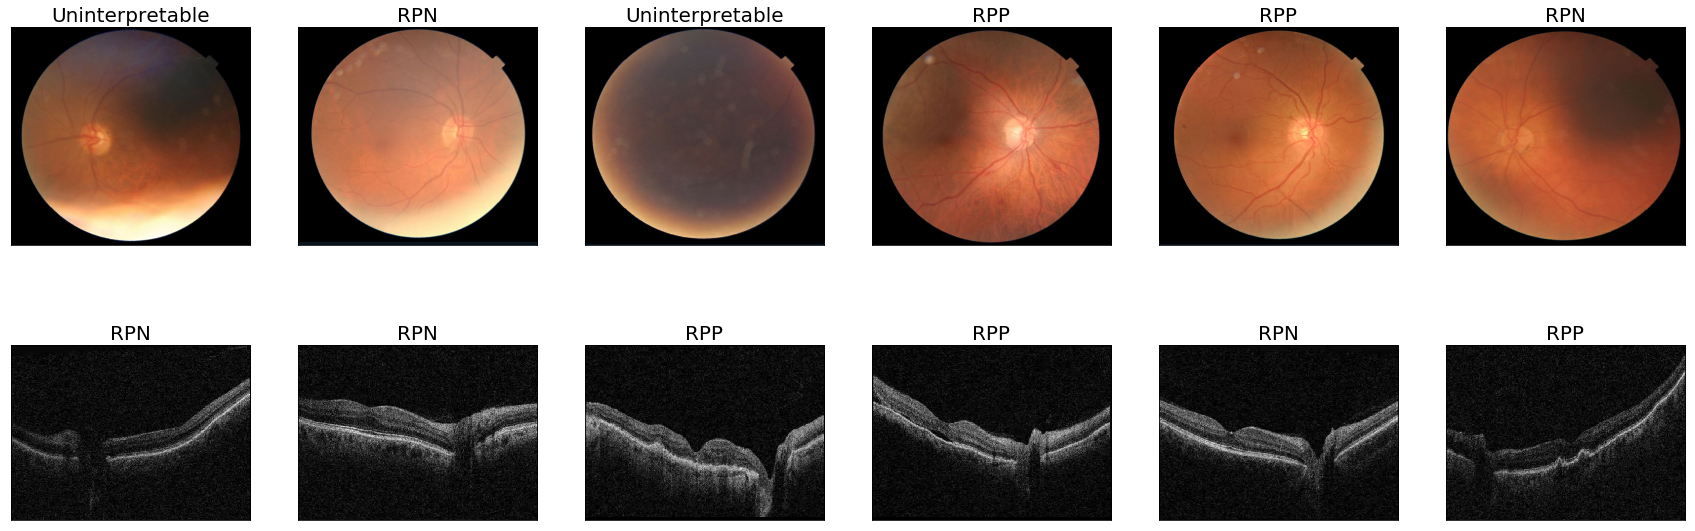

In [19]:
# visualize some OCT and CFP

f, ax = plt.subplots(2,6,figsize=(30,10))
for i in range(6):
    current_cfp_img = imresize(imageio.imread(df_example_imgs['path'].values[i*2]), (653,717,3))
#     ax.flatten()[i].imshow(imresize(gen_cam(cfp_features[i,:,:,:], fc_weights[0,0,:2048,label_results[i]]),current_cfp_img.shape[:-1]), cmap='jet')
    ax.flatten()[i].imshow(current_cfp_img)
    ax.flatten()[i].set_xticks([])
    ax.flatten()[i].set_yticks([])
    ax.flatten()[i].set_title(convert_dict[df_example_imgs['pathology'].values[i*2]], fontsize=20)
    current_oct_img = imresize(imageio.imread(df_example_imgs['path'].values[i*2+1]), (479,654,3))
#     ax.flatten()[i+6].imshow(imresize(gen_cam(oct_features[i,:,:,:], fc_weights[0,0,2048:,label_results[i]]),current_oct_img.shape[:-1]), cmap='jet')
    ax.flatten()[i+6].imshow(current_oct_img)
    ax.flatten()[i+6].set_xticks([])
    ax.flatten()[i+6].set_yticks([])
    ax.flatten()[i+6].set_title(convert_dict[df_example_imgs['pathology'].values[i*2+1]], fontsize=20)
f.savefig("sample.png",dpi=200)    

/home/gaoqitong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
/home/gaoqitong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  import sys
/home/gaoqitong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  del sys.path[0]
/home/gaoqitong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and wi

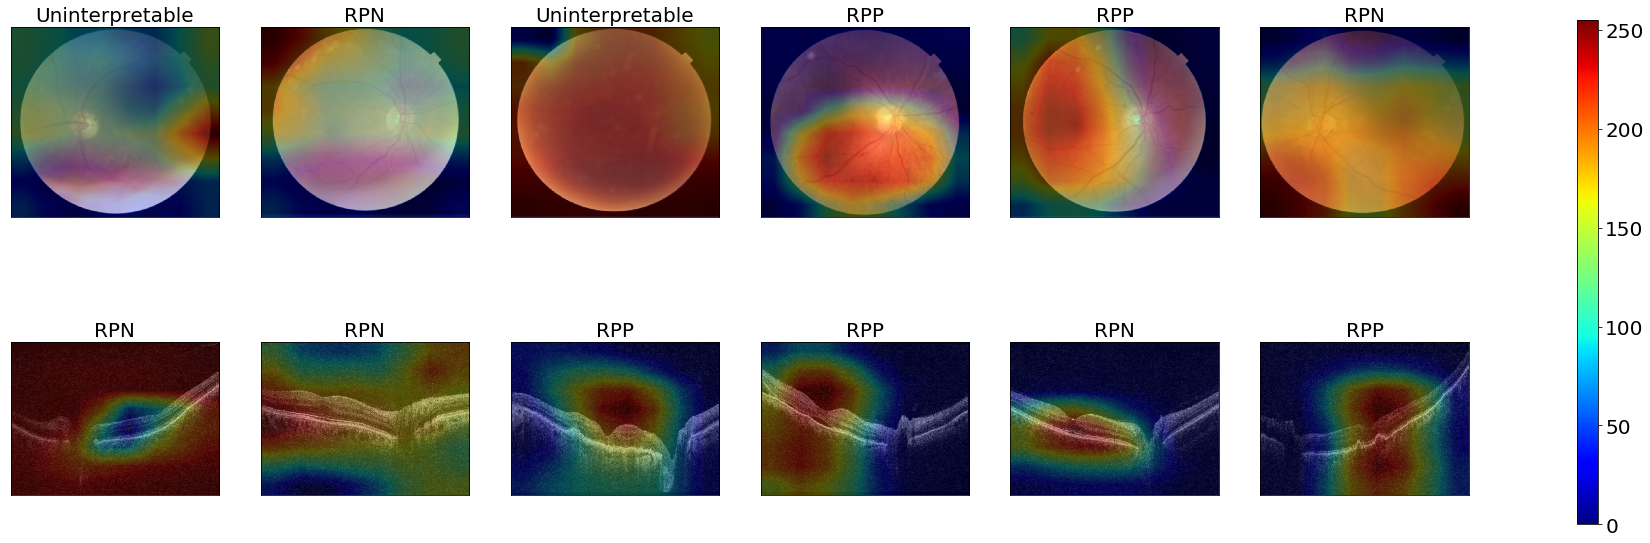

In [21]:
# generating CAMs

f, ax = plt.subplots(2,6,figsize=(30,10))
for i in range(6):
    current_cfp_img = imageio.imread(df_example_imgs['path'].values[i*2])
    ax.flatten()[i].imshow(imresize(gen_cam(cfp_features[i,:,:,:], fc_weights[0,0,:2048,label_results[i]]),(653,717)), cmap='jet')
    ax.flatten()[i].imshow(imresize(current_cfp_img,(653,717,3)), alpha=0.7)
    ax.flatten()[i].set_xticks([])
    ax.flatten()[i].set_yticks([])
    ax.flatten()[i].set_title(convert_dict[df_example_imgs['pathology'].values[i*2]], fontsize=20)
    current_oct_img = imageio.imread(df_example_imgs['path'].values[i*2+1])
    im = ax.flatten()[i+6].imshow(imresize(gen_cam(oct_features[i,:,:,:], fc_weights[0,0,2048:,label_results[i]]),(479,654)), cmap='jet')
    ax.flatten()[i+6].imshow(imresize(current_oct_img,(479,654)), alpha=0.7)
    ax.flatten()[i+6].set_xticks([])
    ax.flatten()[i+6].set_yticks([])
    ax.flatten()[i+6].set_title(convert_dict[df_example_imgs['pathology'].values[i*2+1]], fontsize=20)
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = f.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20) 
f.savefig("attention.png",dpi=200)   

0.8859649122807017


Text(0,0.5,'Accuracy')

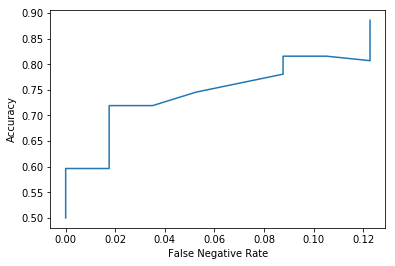

In [22]:
# generate ACC-FNR plot

tf.reset_default_graph()
img_dataset_test = tf.data.Dataset.from_generator(gen_Dataset_test, (tf.float32, tf.float32, tf.float32, tf.bool, tf.bool), (list(images_cfp_normal_test.shape[1:]), list(images_oct_normal_test.shape[1:]), [2], [1], [1])).repeat(1000).batch(NUM_IMG_FROM_NORMAL_TEST+NUM_IMG_FROM_ABNORMAL_TEST)
input_cfp_test, input_oct_test, label_test, interpre_cfp_test, interpre_oct_test = img_dataset_test.make_one_shot_iterator().get_next()    
logits_test, pred_test, _, _ = modified_inception_v3(input_cfp_test, input_oct_test, global_pool=True, trainable=False, reuse=tf.AUTO_REUSE, device=DEVICE)
with tf.Session(config=session_config) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, "./saved_model/FINETUNE_concatLogits_RawForUninterpretable_299Resolution_diffLR_blurOCT_2020_6_19_2_19_52_1e-04_1e-04_1e-04_1500_0.91_SEED_2026_Logits_Mixed_6_Mixed_7/best.ckpt")
#     print sess.run(pred_test)
    pred_probs = sess.run(pred_test)
    pred_results = np.argmax(sess.run(pred_test),axis=1)
    label_results = np.argmax(sess.run(label_test),axis=1)
    print np.sum(np.argmax(sess.run(pred_test),axis=1)==np.argmax(sess.run(label_test),axis=1))/(NUM_IMG_FROM_NORMAL_TEST+NUM_IMG_FROM_ABNORMAL_TEST)
    thresholds = np.linspace(0.5,1,50)
#     thresholds = np.sort(pred_probs[:,1])
    accs = []
    fnrs = []
    for k in range(len(thresholds)):
        pred_thresholded = sess.run(pred_test>thresholds[k])
        for i in range(pred_thresholded.shape[0]):
            if pred_thresholded[i,0]==pred_thresholded[i,1]==False:
                pred_thresholded[i,1]=True
        accs += [np.sum(np.argmax(pred_thresholded,axis=1)==np.argmax(sess.run(label_test),axis=1))/(NUM_IMG_FROM_NORMAL_TEST+NUM_IMG_FROM_ABNORMAL_TEST)]
        pred_thresholded = np.argmax(pred_thresholded,axis=1)
        fnrs += [confusion_matrix(label_results,pred_thresholded)[1][0]/(confusion_matrix(label_results,pred_thresholded)[1][0]+confusion_matrix(label_results,pred_thresholded)[1][1])]
    

plt.plot(fnrs,accs)
plt.xlabel("False Negative Rate")
plt.ylabel("Accuracy")

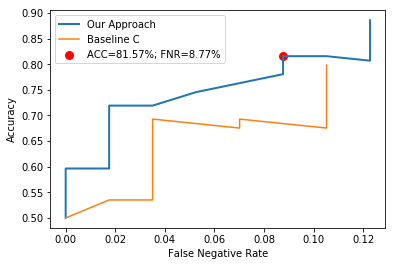

In [23]:
plt.plot(fnrs,accs,linewidth=2, label="Our Approach")
fnrs_baseline_c = np.loadtxt("./fnrs_baseline_c.txt")
accs_baseline_c = np.loadtxt("./accs_baseline_c.txt")
plt.plot(fnrs_baseline_c,accs_baseline_c, label="Baseline C")
plt.scatter(fnrs[15],accs[15], linewidth=3, color='red', label="ACC=81.57%; FNR=8.77%")
# plt.plot([0.14]+fnrs+[-0.04], [accs[15] for i in range(len(fnrs)+2)], '--', linewidth=1, color='red')
# plt.plot([fnrs[15] for i in range(len(accs)+2)], [1]+accs+[0.4], '--', linewidth=1, color='red')
# plt.xlim([-0.005,0.13])
# plt.ylim([0.5,1])
plt.xlabel("False Negative Rate")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("acc-fnr.png", dpi=200)

In [20]:
# Get CIs for the **GRAPH ABOVE** following https://machinelearningmastery.com/report-classifier-performance-confidence-intervals/
# Wilson score interval

def get_CI(metric):
    one_side = 1.96 * np.sqrt(metric*(1-metric)/len(pred_results))
    return metric + one_side, metric - one_side

fnr_thres = 0.0877
acc_thres = 0.8157

upper_acc_thres, lower_acc_thres = get_CI(acc_thres)
upper_fnr_thres, lower_fnr_thres = get_CI(fnr_thres)

print "ACC: %.2f ~ (%.2f, %.2f)" %(acc_thres*100, lower_acc_thres*100, upper_acc_thres*100)
print "FNR: %.2f ~ (%.2f, %.2f)" %(fnr_thres*100, upper_fnr_thres*100, lower_fnr_thres*100)


ACC: 81.57 ~ (74.45, 88.69)
FNR: 8.77 ~ (13.96, 3.58)


## TEST this model with Interpretable images ONLY

In [27]:
def gen_Dataset_test_interpretables_only():
    # Jointly Labelled Normal Imgs
    for i in range(NUM_IMG_FROM_NORMAL_TEST):
        if interpretable_labels_cfp_normal_test[i] != 0 and interpretable_labels_oct_normal_test[i] != 0:
            yield (images_cfp_normal_test[i], images_oct_normal_test[i], np.array([1., 0.]))
    # Jointly Labelled Abnormal Imgs
    for i in range(NUM_IMG_FROM_ABNORMAL_TEST):
        if interpretable_labels_cfp_abnormal_test[i] != 0 and interpretable_labels_oct_abnormal_test[i] != 0:
            yield (images_cfp_abnormal_test[i], images_oct_abnormal_test[i], np.array([0., 1.]))

In [28]:
tf.reset_default_graph()
total_test_interpretable_only = \
    np.sum(np.logical_and(interpretable_labels_cfp_normal_test, interpretable_labels_oct_normal_test)) + \
    np.sum(np.logical_and(interpretable_labels_cfp_abnormal_test, interpretable_labels_oct_abnormal_test))
img_dataset_test_interpretables_only = tf.data.Dataset.from_generator(gen_Dataset_test_interpretables_only, (tf.float32, tf.float32, tf.float32), (list(images_cfp_normal_test.shape[1:]), list(images_oct_normal_test.shape[1:]), [2])).repeat(10).batch(total_test_interpretable_only)
input_cfp_test, input_oct_test, label_test = img_dataset_test_interpretables_only.make_one_shot_iterator().get_next()    
logits_test, pred_test, _, _ = modified_inception_v3(input_cfp_test, input_oct_test, global_pool=True, trainable=False, reuse=tf.AUTO_REUSE, device=DEVICE)
with tf.Session(config=session_config) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, "./saved_model/FINETUNE_concatLogits_RawForUninterpretable_299Resolution_diffLR_blurOCT_2020_6_19_2_19_52_1e-04_1e-04_1e-04_1500_0.91_SEED_2026_Logits_Mixed_6_Mixed_7/best.ckpt")
#     print sess.run(pred_test)
    pred_probs = sess.run(pred_test)
    pred_results = np.argmax(sess.run(pred_test),axis=1)
    label_results = np.argmax(sess.run(label_test),axis=1)
    print np.sum(np.argmax(sess.run(pred_test),axis=1)==np.argmax(sess.run(label_test),axis=1))/(total_test_interpretable_only)
    pred_thresholded = sess.run(pred_test>0.65)
    for i in range(pred_thresholded.shape[0]):
        if pred_thresholded[i,0]==pred_thresholded[i,1]==False:
            pred_thresholded[i,1]=True
    print np.sum(np.argmax(pred_thresholded,axis=1)==np.argmax(sess.run(label_test),axis=1))/(total_test_interpretable_only)
    pred_thresholded = np.argmax(pred_thresholded,axis=1)
    

0.8846153846153846
0.8589743589743589


In [29]:
# Get p-values from McNemar's Test

from mlxtend.evaluate import mcnemar, mcnemar_table

df_results = pd.DataFrame.from_dict(np.hstack([label_results.reshape(-1,1), pred_results.reshape(-1,1)]))
df_results = df_results.rename(columns={0:"label",1:'pred'})

contingency_table = pd.crosstab(df_results['label'],df_results['pred']).values

mcnemar(mcnemar_table(label_results,label_results, pred_results))

(7.111111111111111, 0.007660761135179461)

Confusion matrix, without normalization
[[34  2]
 [ 7 35]]
False Normal Rate:  0.16666666666666666
Recall:  0.8333333333333334
Speicificity:  0.9444444444444444


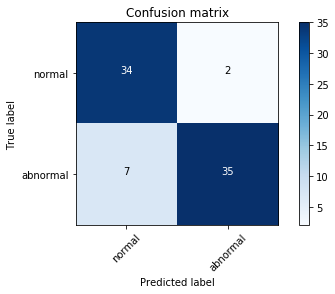

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_matrix(label_results,pred_results), classes=["normal","abnormal"])

fnr = confusion_matrix(label_results,pred_results)[1][0]/(confusion_matrix(label_results,pred_results)[1][0]+confusion_matrix(label_results,pred_results)[1][1])
recall = confusion_matrix(label_results,pred_results)[1][1]/(confusion_matrix(label_results,pred_results)[1][0]+confusion_matrix(label_results,pred_results)[1][1])
specificity = confusion_matrix(label_results,pred_results)[0][0]/(confusion_matrix(label_results,pred_results)[0][0]+confusion_matrix(label_results,pred_results)[0][1])

print "False Normal Rate: ", confusion_matrix(label_results,pred_results)[1][0]/(confusion_matrix(label_results,pred_results)[1][0]+confusion_matrix(label_results,pred_results)[1][1])
print "Recall: ", confusion_matrix(label_results,pred_results)[1][1]/(confusion_matrix(label_results,pred_results)[1][0]+confusion_matrix(label_results,pred_results)[1][1])
print "Speicificity: ", confusion_matrix(label_results,pred_results)[0][0]/(confusion_matrix(label_results,pred_results)[0][0]+confusion_matrix(label_results,pred_results)[0][1])



In [37]:
# Get CIs following https://machinelearningmastery.com/report-classifier-performance-confidence-intervals/
# Wilson score interval

def get_CI(metric):
    one_side = 1.96 * np.sqrt(metric*(1-metric)/len(pred_results))
    return metric + one_side, metric - one_side

acc = 0.8846153846153846

upper_acc, lower_acc = get_CI(acc)
upper_recall, lower_recall = get_CI(recall)
upper_specificity, lower_specificity = get_CI(specificity)

print "ACC: %.2f ~ (%.2f, %.2f)" %(acc*100, lower_acc*100, upper_acc*100)
print "FNR: %.2f ~ (%.2f, %.2f)" %(100-recall*100, 100-upper_recall*100, 100-lower_recall*100)
print "RECALL: %.2f ~ (%.2f, %.2f)" %(recall*100, lower_recall*100, upper_recall*100)
print "SPEICIFICITY: %.2f ~ (%.2f, %.2f)" %(specificity*100, lower_specificity*100, upper_specificity*100)

ACC: 88.46 ~ (81.37, 95.55)
FNR: 16.67 ~ (8.40, 24.94)
RECALL: 83.33 ~ (75.06, 91.60)
SPEICIFICITY: 94.44 ~ (89.36, 99.53)


In [36]:
fpr,tpr,_ = roc_curve(y_true=label_results,y_score=pred_probs[:,1])
auc_our = auc(fpr,tpr)

def get_CI_for_auc(auc, n_pos=np.sum(label_results==1), n_neg=np.sum(label_results==0)):
    q_1 = auc/(2-auc)
    q_2 = 2*auc**2/(1+auc)
    one_side = 1.96 * np.sqrt((auc*(1-auc)+(n_pos-1)*(q_1-auc**2)+(n_neg-1)*(q_2-auc**2))/(n_pos*n_neg))
    return auc+one_side, auc-one_side

auc_our_upper, auc_our_lower = get_CI_for_auc(auc_our)
print "OUR AUC: %.2f ~ (%.2f, %.2f)" %(auc_our*100, auc_our_lower*100, auc_our_upper*100)

OUR AUC: 93.85 ~ (88.39, 99.31)
